In [1]:
#!pip install "numpy<2"

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Define model structure

In [2]:
# Model Definition
class KeyPointModel(nn.Module):
    def __init__(self):
        super(KeyPointModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 24)  # 12 key points (24 coordinates) - add fuly connected layer

    def forward(self, x):
        return self.resnet(x)


# load data

In [3]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Instantiate the model
model = KeyPointModel()
model.train()  # Set to training mode

# Dataset Definition
class KeyPointDataset(Dataset):
    def __init__(self, image_paths, key_points, transform=None):
        self.image_paths = image_paths
        self.key_points = key_points
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        key_point = self.key_points[idx]

        if self.transform:
            image = self.transform(image)

        return image, key_point

# Function to load dataset from a specified folder
def load_dataset(folder_path):
    # Load key points from the CSV file
    csv_file = os.path.join(folder_path, 'augmented_labels.csv')  # Change to your CSV file name
    keypoint_data = pd.read_csv(csv_file)

    # Create lists for images and key points
    image_paths = []
    key_points = []

    # Iterate through the CSV to get paths and key points
    for index, row in keypoint_data.iterrows():
        image_name = row['image_name']  # Replace with the actual column name in your CSV
        keypoint = row[1:].values.astype(float)  # Assuming the first column is the image name
        image_path = os.path.join(folder_path, f"{image_name}")  # Assuming images are in PNG format

        image_paths.append(image_path)
        key_points.append(torch.tensor(keypoint))

    return image_paths, key_points

# Base path for your project
base_path = os.path.expanduser('~/Documents/GitHub/ViT_facemap/ViT-pytorch/projects/Facemap/data')

# Paths to your train and test folders
train_folder = os.path.join(base_path, 'train', 'augmented_data')
test_folder = os.path.join(base_path, 'test', 'augmented_data')

# Load datasets
train_image_paths, train_key_points = load_dataset(train_folder)
test_image_paths, test_key_points = load_dataset(test_folder)

# Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create DataLoaders
train_dataset = KeyPointDataset(train_image_paths, train_key_points, transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = KeyPointDataset(test_image_paths, test_key_points, transform)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


/Users/annastuckert/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/annastuckert/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# train network

In [4]:

# Training Loop
num_epochs = 10  # Number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets.float())  # Ensure targets are float
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Print progress every 10 batches (adjust as needed)
        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    # Print the average loss for the epoch
    avg_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Save the trained model if needed
torch.save(model.state_dict(), 'keypoint_model.pth')



Epoch [1/10], Batch [0/225], Loss: 11524.8672


KeyboardInterrupt: 

# Plotting predictions via forward pass

/Users/annastuckert/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/annastuckert/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


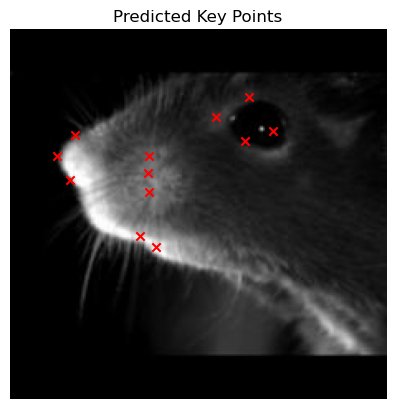

In [5]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = KeyPointModel()
model.load_state_dict(torch.load('keypoint_model_trained.pth'))
model.eval()  # Set to evaluation mode

# Function to preprocess an image
def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to visualize predictions
def visualize_predictions(image_path, keypoints):
    # Load and display the original image
    original_image = Image.open(image_path)
    plt.imshow(original_image)
    
    # Convert keypoints to a numpy array and plot them
    x_coords = keypoints[0::2]
    y_coords = keypoints[1::2]
    plt.scatter(x_coords, y_coords, c='red', marker='x')
    plt.title('Predicted Key Points')
    plt.axis('off')
    plt.show()

# Path to the image you want to predict key points for
# Base path for your project
base_path = os.path.expanduser('~/Documents/GitHub/ViT_facemap/ViT-pytorch/projects/Facemap/data')

# Directory containing the images
image_folder = os.path.join(base_path, 'test', 'augmented_data')

# Get the first image in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
if not image_files:
    raise ValueError("No images found in the specified folder.")
image_path = os.path.join(image_folder, image_files[0])


# Preprocess the image
input_image = preprocess_image(image_path)

# Perform a forward pass to get predictions
with torch.no_grad():
    predicted_keypoints = model(input_image)

# Convert predictions to numpy array and detach from the graph
predicted_keypoints = predicted_keypoints.squeeze().numpy()

# Visualize the predicted key points
visualize_predictions(image_path, predicted_keypoints)


# SHAP maybe works?

/Users/annastuckert/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/annastuckert/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


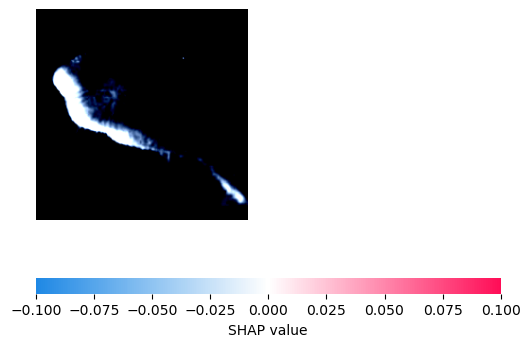

In [6]:
import os
import shap
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model = KeyPointModel()
model.load_state_dict(torch.load('keypoint_model_trained.pth'))
model.eval()

# Prepare the transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to prepare input for SHAP
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Directory containing the images
# Base path for your project
base_path = os.path.expanduser('~/Documents/GitHub/ViT_facemap/ViT-pytorch/projects/Facemap/data')

# Directory containing the images
image_folder = os.path.join(base_path, 'test', 'augmented_data')

# Get the first image in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')]
if not image_files:
    raise ValueError("No images found in the specified folder.")
first_image_path = os.path.join(image_folder, image_files[0])

# Prepare the image for SHAP analysis
images = preprocess_image(first_image_path)

# Reshape images to 2D (num_samples, num_features)
images_reshaped = images.view(images.size(0), -1)  # Flatten each image

# Create a SHAP explainer
def model_predict(input_data):
    input_data = torch.tensor(input_data, dtype=torch.float32)  # Ensure input is a tensor
    with torch.no_grad():
        return model(input_data.view(-1, 3, 224, 224)).numpy()  # Reshape back to original image size

# Initialize the Kernel Explainer with flattened images
explainer = shap.KernelExplainer(model_predict, images_reshaped.numpy())

# Calculate SHAP values
shap_values = explainer.shap_values(images_reshaped.numpy())

# Visualize SHAP values for the first image
shap.initjs()

# Remove the batch dimension for visualization
images_for_plotting = images.squeeze(0).permute(1, 2, 0).numpy()  # Shape to (224, 224, 3)

shap.image_plot(shap_values, images_for_plotting)


# SHAP based on each KP

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20ResNet50%20using%20the%20Partition%20explainer.html 

In [7]:
import os
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image

# Load the trained model
model = KeyPointModel()
model.load_state_dict(torch.load('keypoint_model_trained.pth'))
model.eval()

# Function to load dataset from a specified folder
def load_dataset(folder_path):
    # Load key points from the CSV file
    csv_file = os.path.join(folder_path, 'augmented_labels.csv')  # Change to your CSV file name
    keypoint_data = pd.read_csv(csv_file)

    # Create lists for images and key points
    image_paths = []
    key_points = []

    # Iterate through the CSV to get paths and key points
    for index, row in keypoint_data.iterrows():
        image_name = row['image_name']  # Replace with the actual column name in your CSV
        keypoint = row[1:].values.astype(float)  # Assuming the first column is the image name
        image_path = os.path.join(folder_path, f"{image_name}")  # Assuming images are in PNG format

        image_paths.append(image_path)
        key_points.append(torch.tensor(keypoint))

    return image_paths, key_points

# Function to load and preprocess images
def load_and_preprocess_images(image_paths):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to model's input size
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
    ])
    
    images = []
    for path in image_paths:
        image = Image.open(path).convert('RGB')  # Load image and convert to RGB
        image = transform(image)  # Apply transformations
        images.append(image)
    
    return torch.stack(images)  # Stack images into a single tensor

# Base path for your project
base_path = os.path.expanduser('~/Documents/GitHub/ViT_facemap/ViT-pytorch/projects/Facemap/data')

# Paths to your train and test folders
train_folder = os.path.join(base_path, 'train', 'augmented_data')
test_folder = os.path.join(base_path, 'test', 'augmented_data')

# Load datasets
train_image_paths, train_key_points = load_dataset(train_folder)
test_image_paths, test_key_points = load_dataset(test_folder)

# Load and preprocess images
X_train = load_and_preprocess_images(train_image_paths)
X_test = load_and_preprocess_images(test_image_paths)

# Convert key points to tensors
y_train = torch.stack(train_key_points)
y_test = torch.stack(test_key_points)


In [ ]:
import shap
import numpy as np

# Assuming 'model' is your trained ResNet50 and 'X_train' is your training data
explainer = shap.DeepExplainer(model, X_train)


In [ ]:
# 'X_test' is your test data for which you want explanations
shap_values = explainer.shap_values(X_test)


In [ ]:
for i in range(12):  # Loop through each key point
    shap.initjs()
    shap.summary_plot(shap_values[i], X_test, feature_names=your_feature_names)
